## Plot feature distribution over time

In [3]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,race_name,date_time,race_id,n_runners,place_num,name,number,current_betting_odds,current_place_odds,...,TrainerSurfacePercentageBeaten,TrainerTrackPercentageBeaten,TrainerClassPercentageBeaten,DistanceDifference,RaceClassDifference,HasJockeyChanged,HasTrainerChanged,JockeyWeight,WeightAllowanceExtractor,MaxPastRatingExtractor
0,0,Sedgefield 1,2016-01-31 14:45:00,1800571,10,3,Western Rules,1,2.78,1.28,...,0.711923,0.551599,0.680710,117.0,0.0,0.0,0.0,74.8,0.0,NaN
1,1,Sedgefield 1,2016-01-31 14:45:00,1800571,10,3,Ash Park,2,376.62,25.00,...,0.568185,0.556699,0.529791,-120.0,-1.0,0.0,0.0,72.1,3.2,NaN
2,2,Sedgefield 1,2016-01-31 14:45:00,1800571,10,3,Bertielicious,3,1000.00,305.85,...,0.415142,0.483508,0.574629,834.0,-1.0,0.0,0.0,72.1,3.2,68.0
3,3,Sedgefield 1,2016-01-31 14:45:00,1800571,10,3,General Mahler,4,23.98,3.55,...,0.713361,0.809881,0.704764,864.0,-2.0,0.0,0.0,72.1,0.0,NaN
4,4,Sedgefield 1,2016-01-31 14:45:00,1800571,10,3,Killone,5,219.17,19.67,...,0.568185,0.556699,0.529791,833.0,2.0,0.0,0.0,72.1,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615592,615592,Newcastle 8,2023-01-26 20:30:00,5698429,8,3,Brazen Bolt,4,13.00,3.10,...,0.540264,0.493052,0.700653,0.0,0.0,1.0,0.0,61.2,0.0,80.0
615593,615593,Newcastle 8,2023-01-26 20:30:00,5698429,8,3,Prince Of Bel Lir,5,10.55,2.99,...,0.403825,0.591223,0.438022,-213.0,0.0,1.0,0.0,61.2,1.4,84.0
615594,615594,Newcastle 8,2023-01-26 20:30:00,5698429,8,3,Asadjumeirah,6,8.80,2.63,...,0.669942,0.476526,0.531028,-14.0,0.0,1.0,0.0,59.4,0.0,86.0
615595,615595,Newcastle 8,2023-01-26 20:30:00,5698429,8,3,Minesbiggerthanurs,7,11.33,3.05,...,0.664702,0.507793,0.679338,-14.0,0.0,1.0,0.0,59.4,1.4,NaN


                 std
year-month          
2016-01     0.000000
2016-02     0.024804
2016-03     0.028696
2016-04     0.033356
2016-05     0.020357
...              ...
2022-09     0.032998
2022-10     0.029217
2022-11     0.040760
2022-12     0.037898
2023-01     0.038921

[83 rows x 1 columns]


<AxesSubplot:xlabel='HasFallen', ylabel='year-month'>

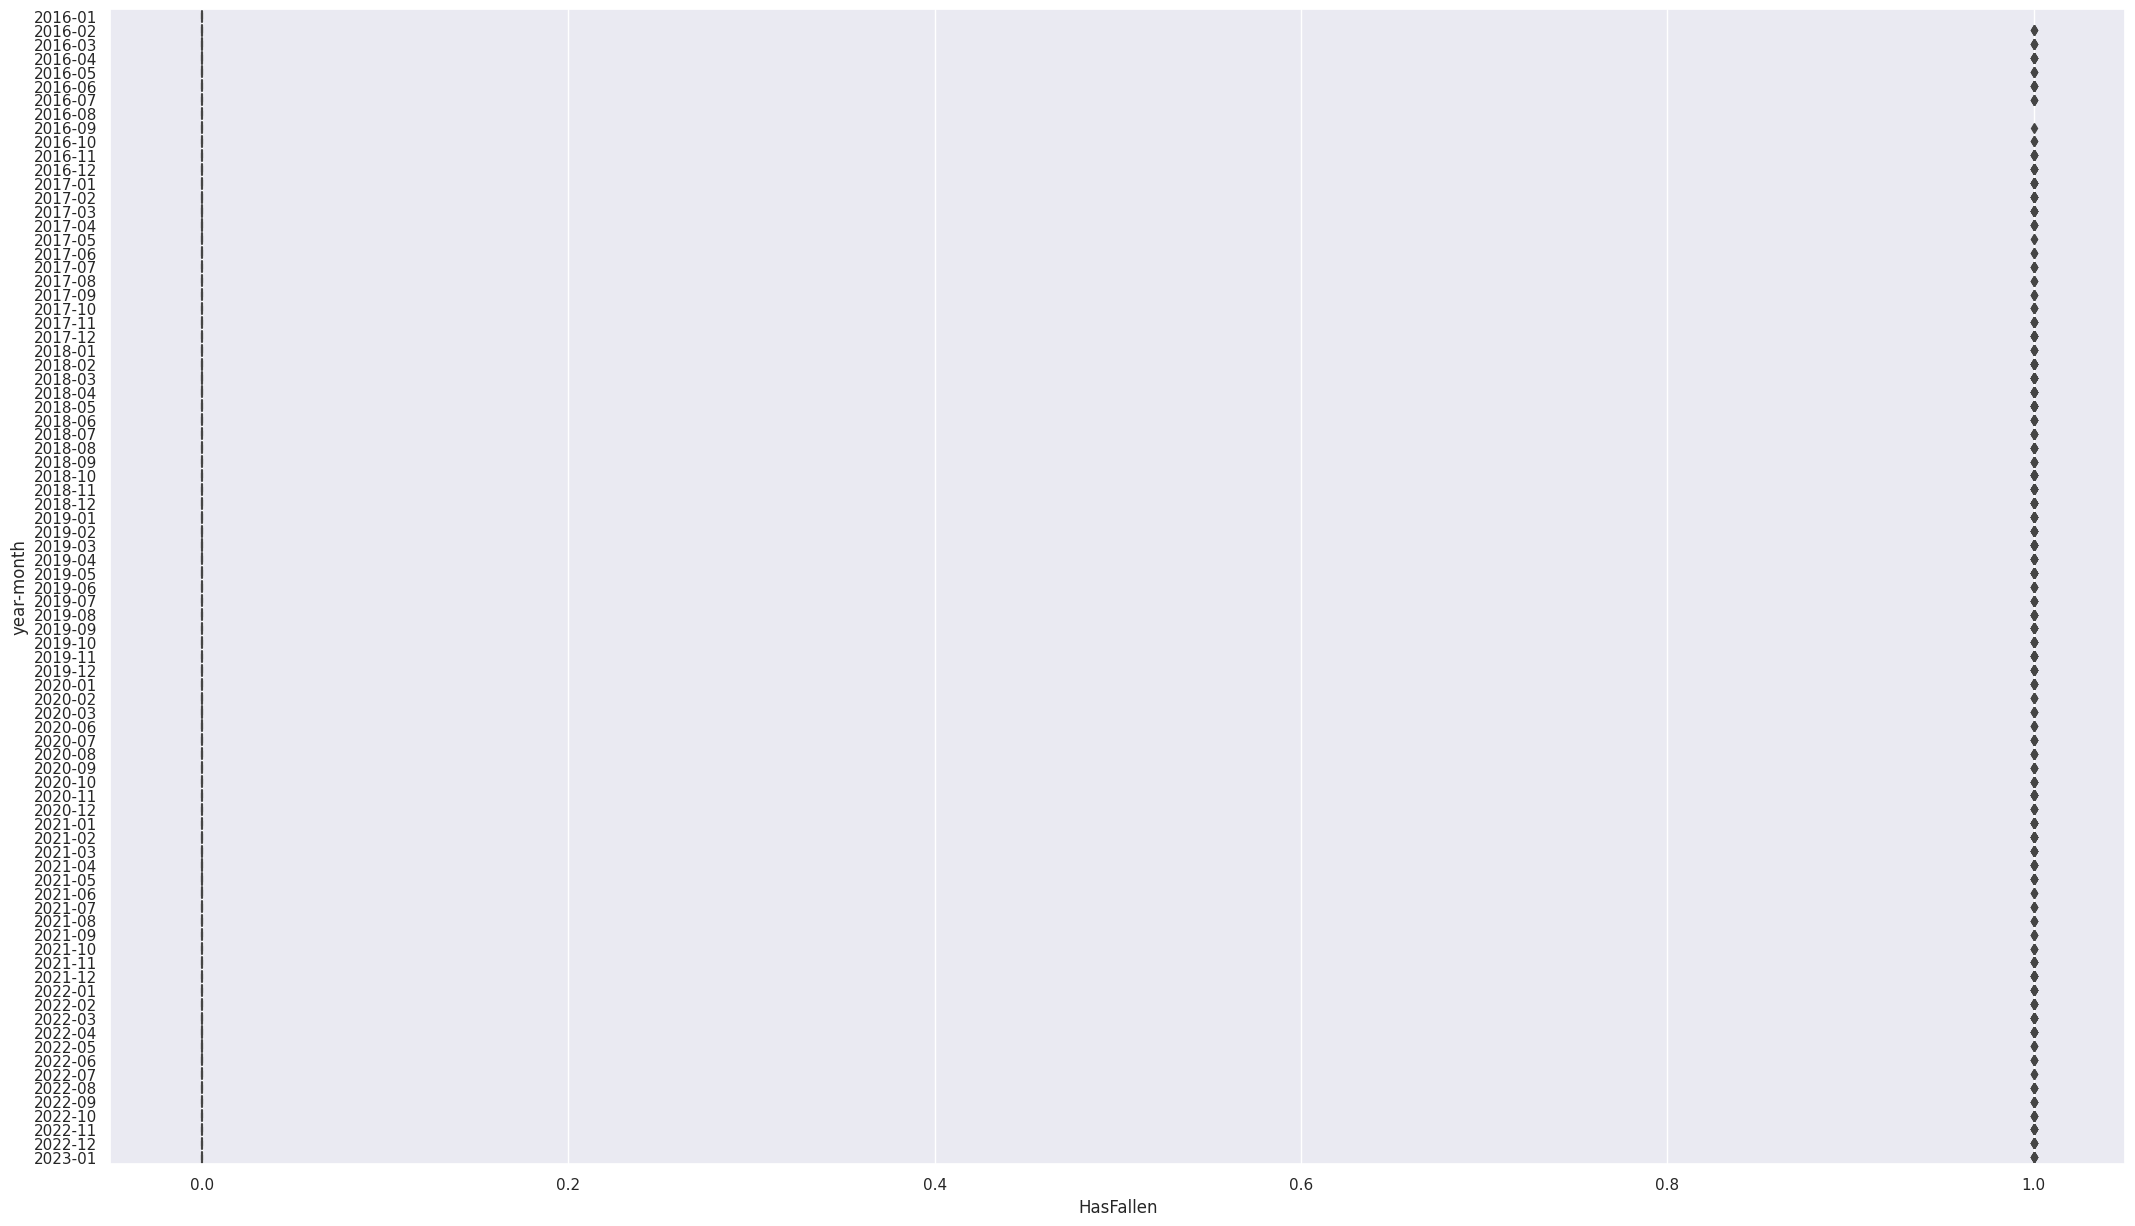

In [4]:
import seaborn as sns

COLUMN_NAME = "HasFallen"
TIME_INTERVAL = "year-month"

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["minute"] = races_df["date"].dt.minute.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "std")))

sns.set(rc={'figure.figsize':(26,15)})
sns.boxplot(data=races_df, x=COLUMN_NAME, y=TIME_INTERVAL)

/tmp/ipykernel_16552/1924257147.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distances)


<AxesSubplot:ylabel='Density'>

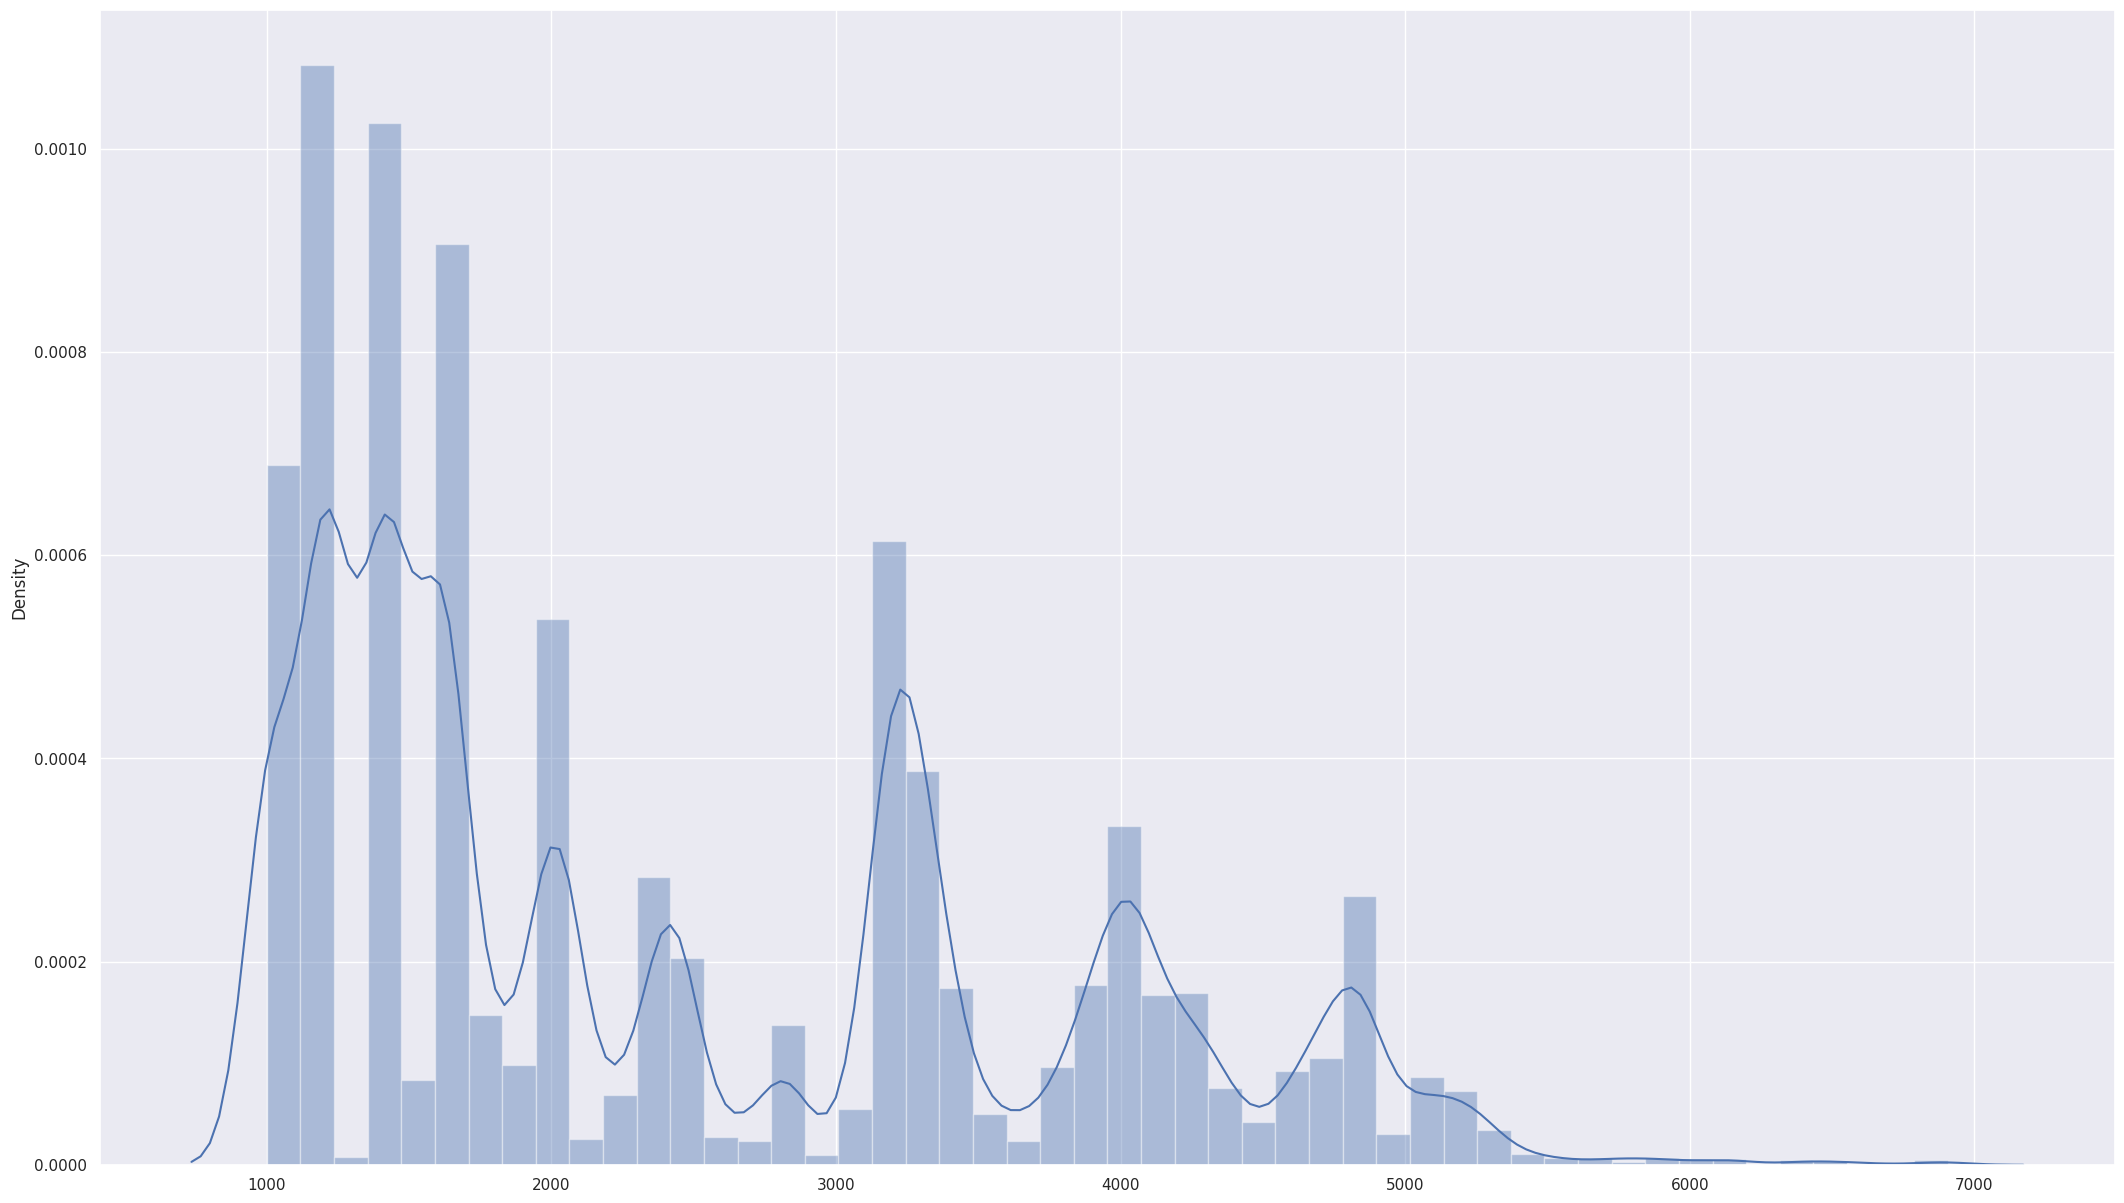

In [11]:
distances = list(races_df["CurrentDistance"].values)

sns.distplot(distances)

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458


## Real time sample inspection

In [1]:
import pandas as pd

real_time_sample_df = pd.read_csv("../data/logs/samples/real_time_5686367")

real_time_sample_df

,Unnamed: 0,race_name,date_time,race_id,n_runners,place_num,name,number,current_estimation_odds,current_betting_odds,...,JockeySurfacePercentageBeaten,JockeyTrackPercentageBeaten,JockeyClassPercentageBeaten,TrainerTrackPercentageBeaten,DistanceDifference,RaceClassDifference,HasTrainerChanged,JockeyWeight,WeightAllowanceExtractor,MaxPastRatingExtractor
0,0,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Ehteyat,1,2.1,2.37,...,0.516215,0.532121,0.714311,0.749237,337,0.0,0,65.8,0.0,NaN
1,1,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Dance To Paris,2,8.0,6.00,...,0.600373,0.552925,0.753614,0.717757,-44,3.0,0,64.4,0.0,82.0
2,2,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,September Power,3,13.0,10.00,...,0.514251,0.568831,0.459088,0.485482,0,0.0,0,61.2,0.0,71.0
3,3,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,First Emperor,4,19.0,15.00,...,0.497108,0.510266,0.548389,0.383615,0,0.0,0,59.9,0.0,82.0
4,4,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Independence,5,34.0,26.00,...,0.404414,0.281876,0.225695,0.443218,759,0.0,0,59.9,0.0,101.0
5,5,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Smith,6,11.0,9.00,...,0.581062,0.659107,0.708179,0.652143,0,0.0,0,59.9,3.2,65.0
6,6,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Sharp Distinction,7,7.0,8.50,...,0.466521,0.423868,0.537283,0.352511,337,0.0,0,59.0,0.0,75.0
7,7,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Reeceltic,8,9.5,9.00,...,0.565401,0.504532,0.411143,0.471639,-46,-1.0,0,57.6,1.4,62.0
8,8,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Tamaris,9,13.0,19.00,...,0.524641,0.319345,0.494832,0.571220,-395,0.0,0,56.2,0.0,106.0
9,9,Lingfield 1,2023-01-21 12:55:00,5686367,10,3,Pledge Of Peace,10,67.0,51.00,...,0.719070,0.567992,0.674015,0.320423,758,-1.0,0,54.9,0.0,68.0
